# Fitting Unknown Rp to Process Data

In [1]:
# Since this is running in a Jupyter notebook, need to help it find LyoPRONTO
# For the documentation, the path is nearby.
# If you have already installed LyoPRONTO as a Python package,
# this should be unnecessary.
import sys
sys.path.append('../../')

In [2]:
import scipy.optimize as sp
import numpy as np
import csv
import matplotlib.pyplot as plt
from matplotlib import rc as matplotlibrc
import time

# from lyopronto.calc_unknownRp import dry

from lyopronto import *

In [3]:


################################################################

######################## Inputs ########################

sim = dict([('tool','Primary Drying Calculator'),('Kv_known','Y'),('Rp_known','N'),('Variable_Pch','N'),('Variable_Tsh','N')])

# Vial and fill properties
# Av = Vial area in cm^2
# Ap = Product Area in cm^2
# Vfill = Fill volume in mL
vial = dict([('Av',3.80),('Ap',3.14),('Vfill',2.0)])

#Product properties
# cSolid = Fractional concentration of solute in the frozen solution
# Tpr0 = Initial product temperature for freezing in degC
# Tf = Freezing temperature in degC
# Tn = Nucleation temperature in degC
# Product Resistance Parameters
# R0 in cm^2-hr-Torr/g, A1 in cm-hr-Torr/g, A2 in 1/cm
product = dict([('cSolid',0.05)])
# Experimental product temperature measurements: format - t(hr), Tp(C)
product_temp_filename = './temperature.txt'
# Critical product temperature
# At least 2 to 3 deg C below collapse or glass transition temperature
product['T_pr_crit'] = -5        # in degC

# Vial Heat Transfer Parameters
# Kv = KC + KP*Pch/(1+KD*Pch) 
# KC in cal/s/K/cm^2, KP in cal/s/K/cm^2/Torr, KD in 1/Torr
ht = dict([('KC',2.75e-4),('KP',8.93e-4),('KD',0.46)])

# Chamber Pressure
Pchamber = dict([('setpt',[0.15]),('dt_setpt',[1800.0]),('ramp_rate',0.5)])

# Shelf Temperature
# init = Intial shelf temperature in C
# setpt = Shelf temperature set points in C
# dt_setpt = Time for which shelf temperature set points are held in min
# ramp_rate = Shelf temperature ramping rate in C/min
Tshelf = dict([('init',-35.0),('setpt',[20.0]),('dt_setpt',[1800.0]),('ramp_rate',1.0)])

# Time step
dt = 0.01    # hr

# Lyophilizer equipment capability
# Form: dm/dt [kg/hr] = a + b * Pch [Torr]
# a in kg/hr, b in kg/hr/Torr 
eq_cap = dict([('a',-0.182),('b',0.0117e3)])

# Equipment load
nVial = 398    # Number of vials

########################################################

#################### Input file saved ##################

# Write data to files
#save input_saved.csv

# current_time = time.strftime("%y%m%d_%H%M",time.localtime())
# csvfile = open('input_saved_'+current_time+'.csv', 'w')

# try:
#     writer = csv.writer(csvfile)
#     writer.writerow(['Tool:',sim['tool']])
#     writer.writerow(['Kv known?:',sim['Kv_known']])
#     writer.writerow(['Rp known?:',sim['Rp_known']])
#     writer.writerow(['Variable Pch?:',sim['Variable_Pch']])
#     writer.writerow(['Variable Tsh?:',sim['Variable_Tsh']])
#     writer.writerow([''])
    
#     writer.writerow(['Vial area [cm^2]',vial['Av']])
#     writer.writerow(['Product area [cm^2]',vial['Ap']])
#     writer.writerow(['Vial fill volume [mL]',vial['Vfill']])
#     writer.writerow([''])
    
#     writer.writerow(['Fractional solute concentration:',product['cSolid']])
#     writer.writerow(['Critical product temperature [C]:', product['T_pr_crit']])
#     writer.writerow([''])
    
#     writer.writerow(['KC [cal/s/K/cm^2]:',ht['KC']])
#     writer.writerow(['KP [cal/s/K/cm^2/Torr]:',ht['KP']])
#     writer.writerow(['KD [1/Torr]:',ht['KD']])
#     writer.writerow([''])
    
#     for i in range(len(Pchamber['setpt'])):
#         writer.writerow(['Chamber pressure setpoint [Torr]:',Pchamber['setpt'][i],'Duration [min]:',Pchamber['dt_setpt'][i]])
#     writer.writerow(['Chamber pressure ramping rate [Torr/min]:',Pchamber['ramp_rate']])
#     writer.writerow([''])
    
#     for i in range(len(Tshelf['setpt'])):
#         writer.writerow(['Shelf temperature setpoint [C]:',Tshelf['setpt'][i],'Duration [min]:',Tshelf['dt_setpt'][i]])
#     writer.writerow(['Shelf temperature ramping rate [C/min]:',Tshelf['ramp_rate']])
#     writer.writerow([''])
    
#     writer.writerow(['Time step [hr]:',dt])
#     writer.writerow([''])
    
#     writer.writerow(['Equipment capability parameters:','a [kg/hr]:',eq_cap['a'],'b [kg/hr/Torr]:',eq_cap['b']])
#     writer.writerow(['Number of vials:',nVial])    

# finally:
#     csvfile.close()
    

################### Execute  ##########################


###### Primary Drying Calculator Tool

#### Known Kv and Rp
#### Determine Rp based on product temperature

dat = np.loadtxt(product_temp_filename)
time = dat[:,0]
Tbot_exp = dat[:,1]

output_saved, product_res = calc_unknownRp.dry(vial,product,ht,Pchamber,Tshelf,time,Tbot_exp)
params,params_covariance = sp.curve_fit(lambda h,r,a1,a2: r+h*a1/(1+h*a2),product_res[:,1],product_res[:,2],p0=[1.0,0.0,0.0])
print("R0 = "+str(params[0])+"\n")
print("A1 = "+str(params[1])+"\n")
print("A2 = "+str(params[2])+"\n")
#################

##########################


R0 = 0.02089279322037721

A1 = 7.843317942227547

A2 = 0.5081399451752311



In [4]:

# LaTeX setup
matplotlibrc('text.latex', preamble=r'\usepackage{color}')
matplotlibrc('text',usetex=False)
matplotlibrc('font',family='Arial')

figwidth = 30
figheight = 20
lineWidth = 5
markerSize = 20

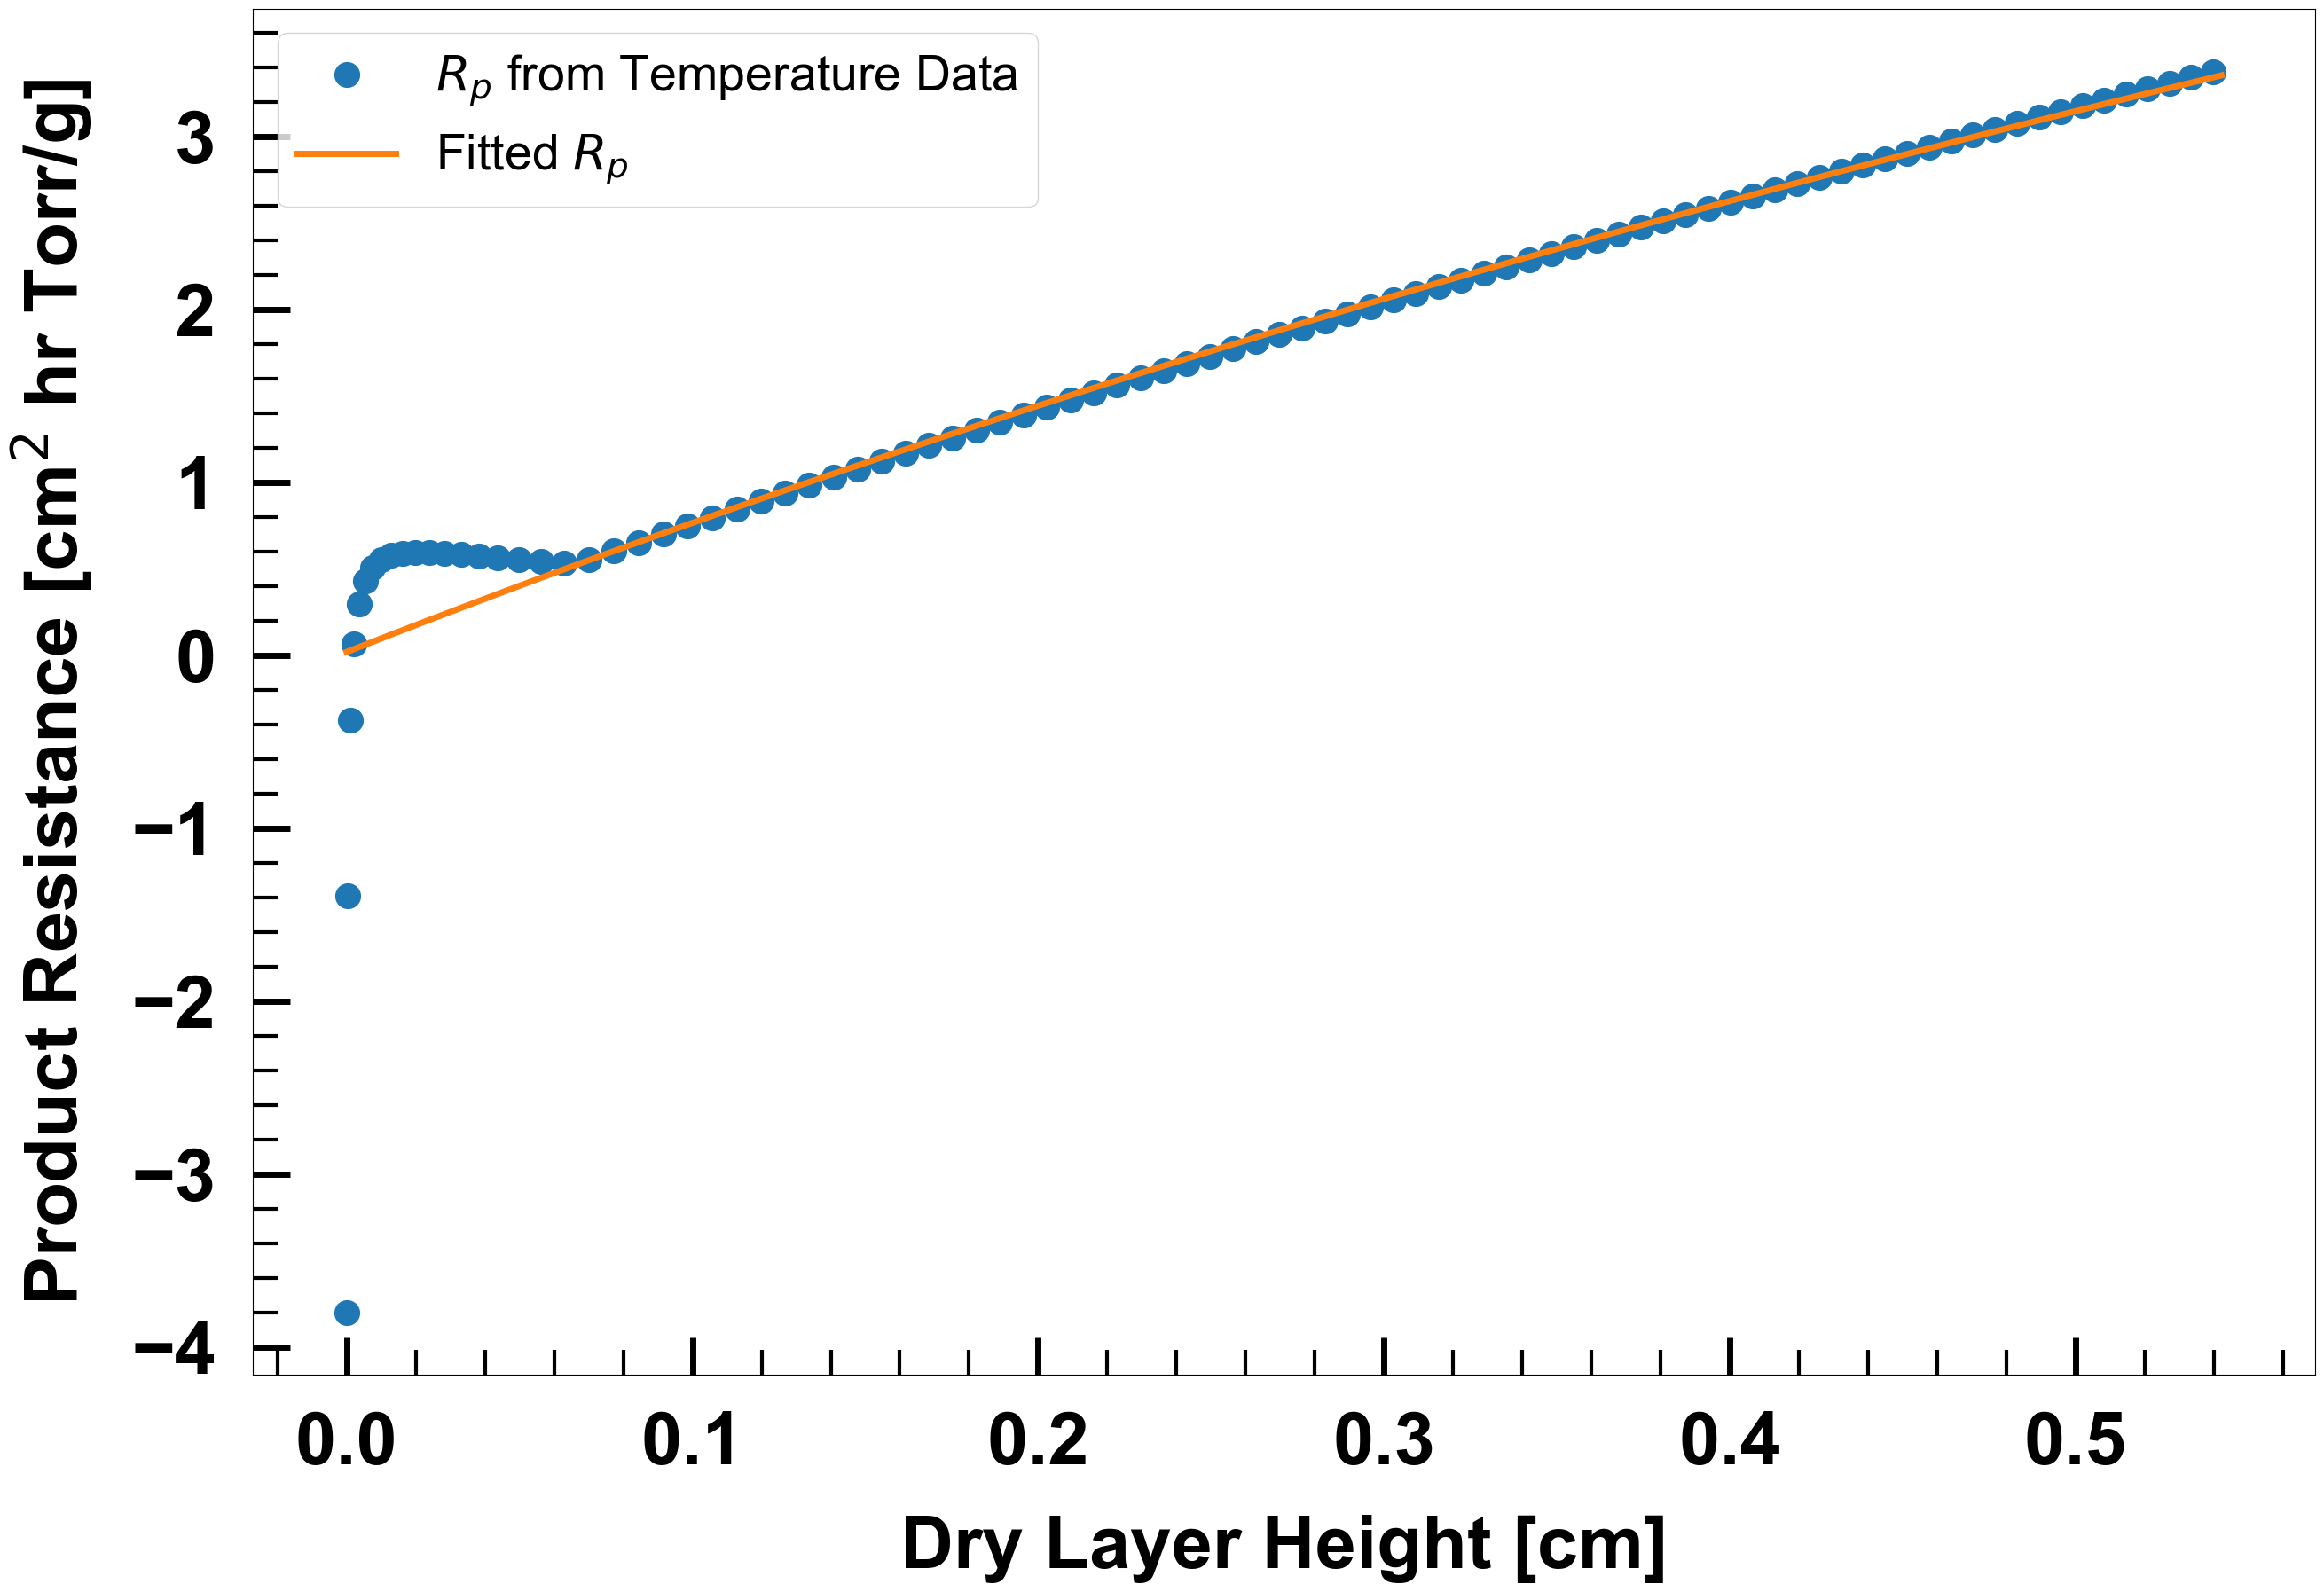

In [8]:
fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(111)
plot_styling.axis_style_rp(ax)
ax.plot(product_res[:,1],product_res[:,2],'o', markevery=5, markersize=markerSize,label='$R_p$ from Temperature Data')
ax.plot(product_res[:,1],params[0]+product_res[:,1]*params[1]/(1+product_res[:,1]*params[2]),'-',linewidth=lineWidth,label='Fitted $R_p$')
plt.legend(fontsize=40, loc='best')

NameError: name 'gcafontSize' is not defined

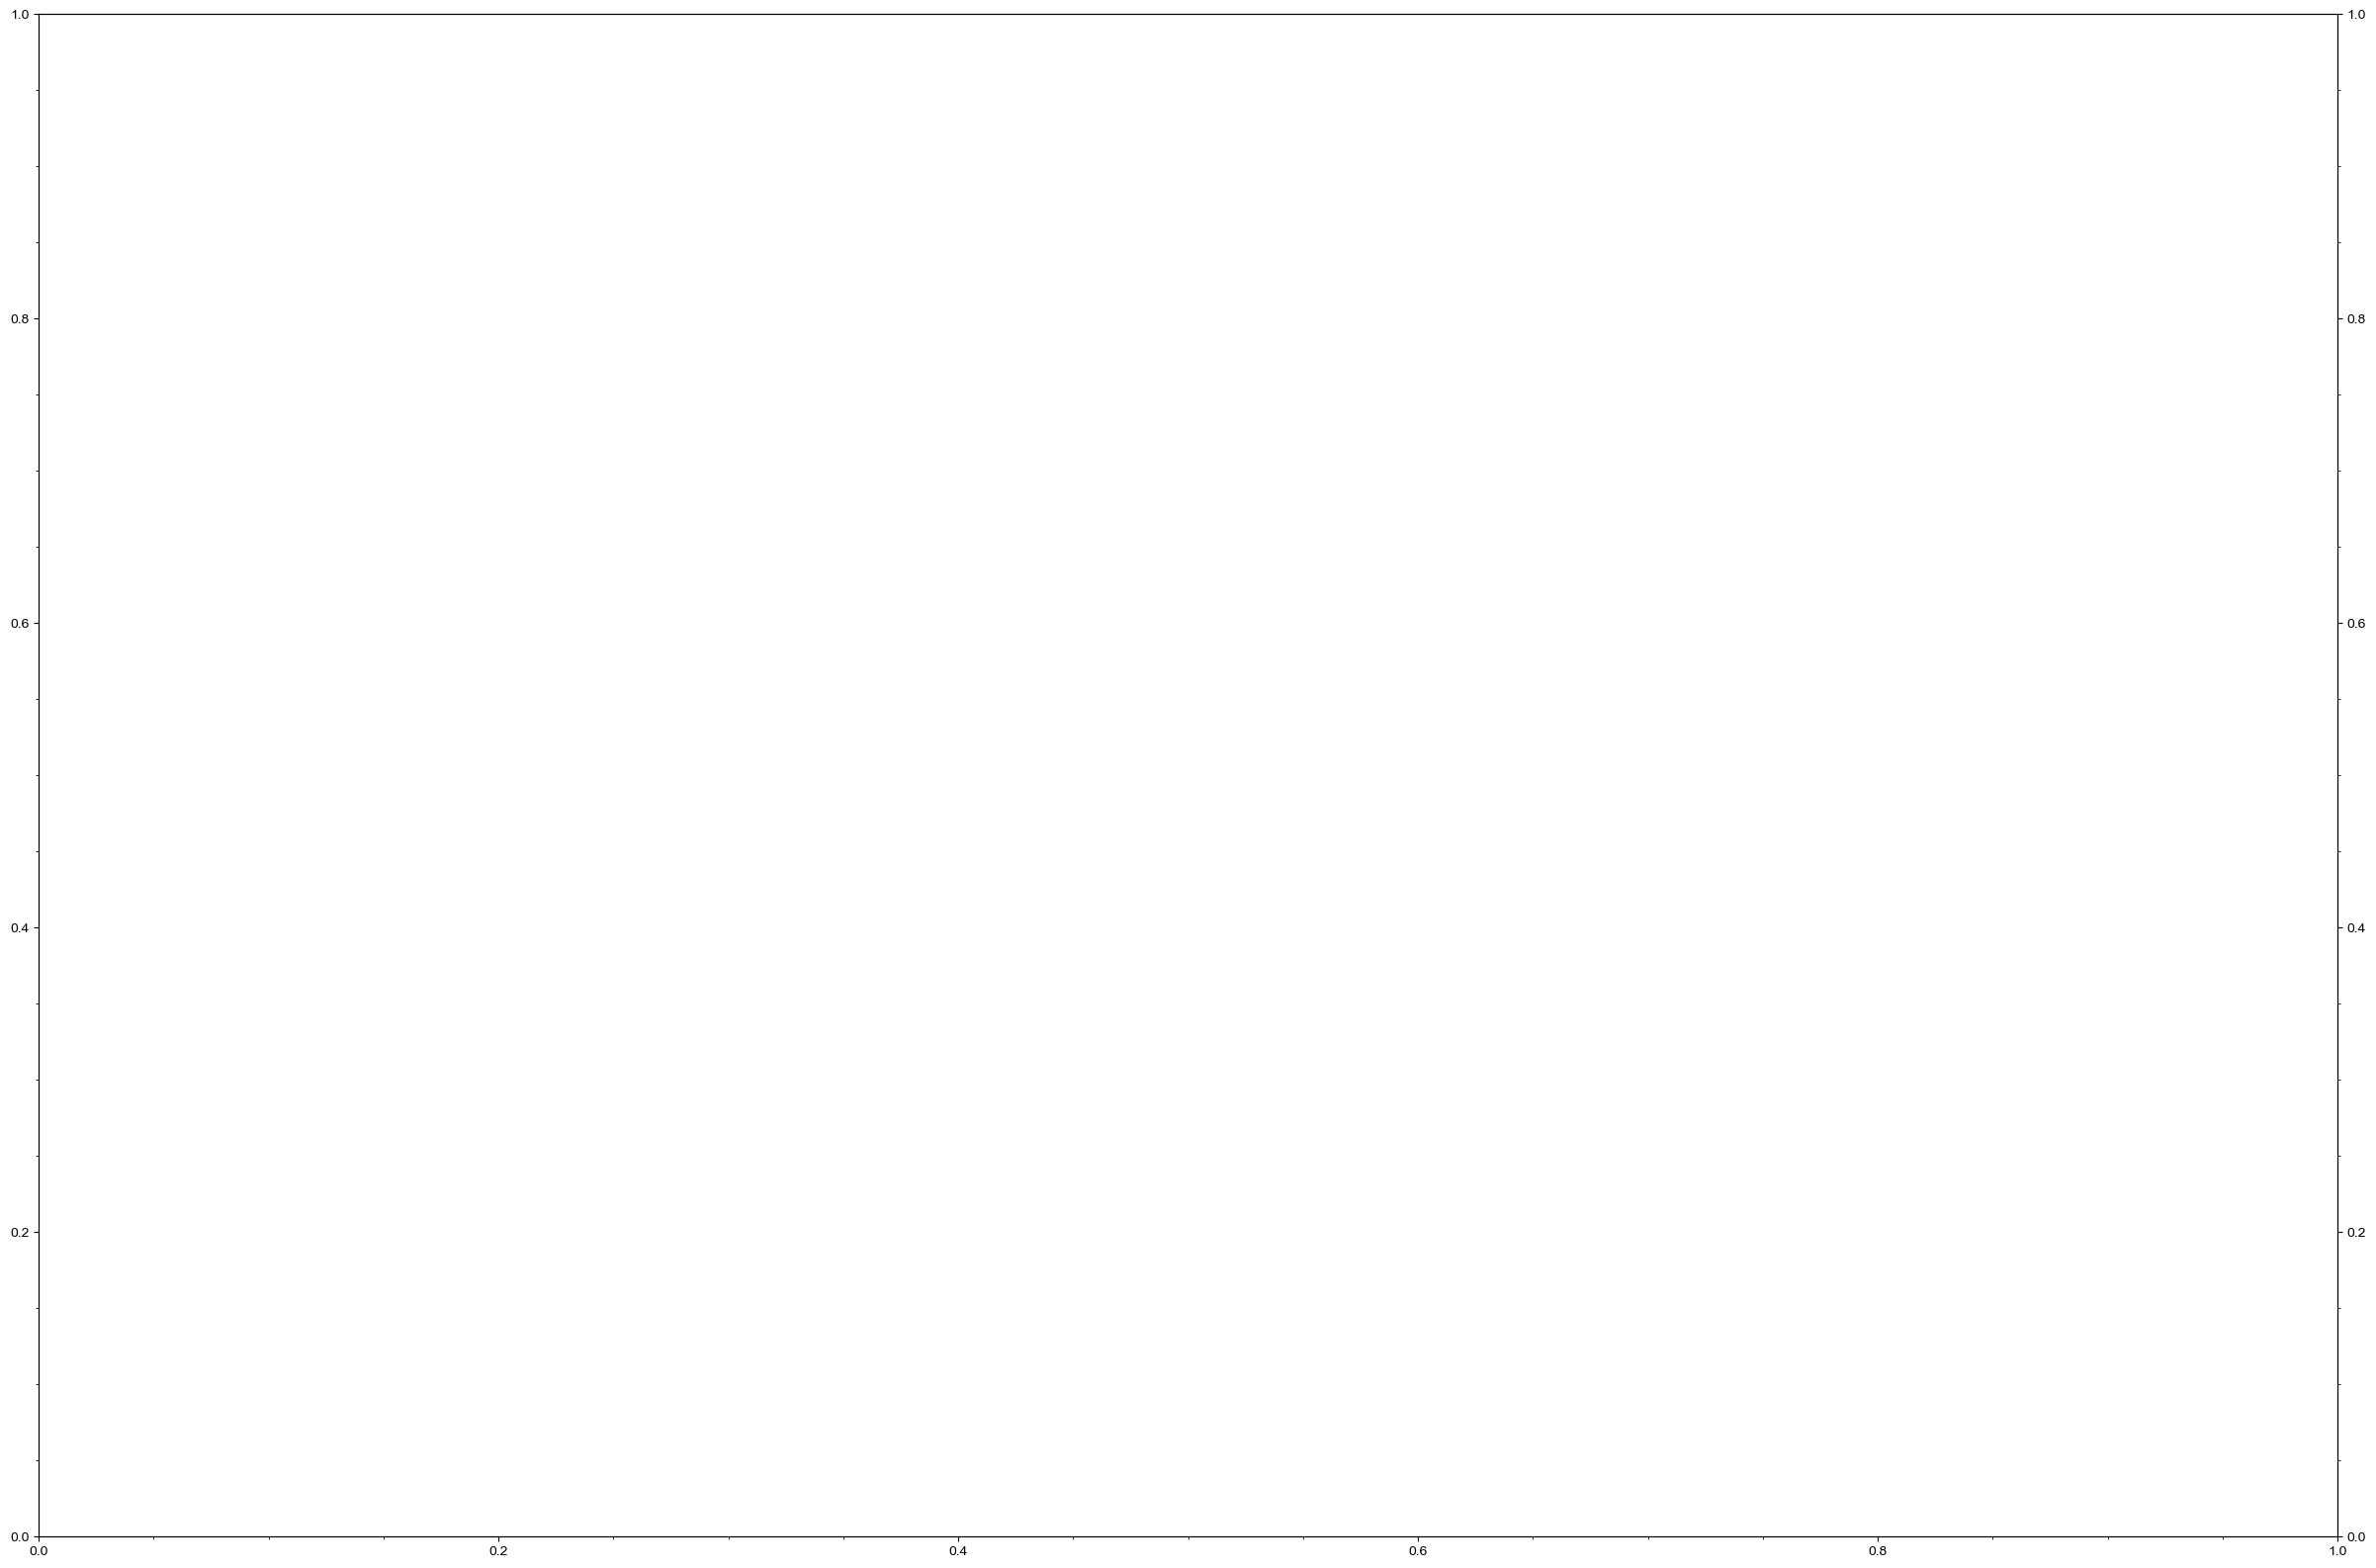

In [6]:


fig = plt.figure(0,figsize=(figwidth,figheight))
ax1 = fig.add_subplot(1,1,1)
ax2 = ax1.twinx()
plt.axes(ax1)
plt.minorticks_on()
plt.axes(ax2)
plt.minorticks_on()
plt.setp(ax1.get_xticklabels(),fontsize=gcafontSize,fontweight='bold',)
plt.setp(ax1.get_yticklabels(),fontsize=gcafontSize,color='b',fontweight='bold',)
plt.setp(ax2.get_yticklabels(),fontsize=gcafontSize,color=[0,0.7,0.3],fontweight='bold',)
ax1.tick_params(axis='x',direction='in',pad=labelPad,width=majorTickWidth,length=majorTickLength,bottom=1,top=0)
ax1.tick_params(axis='y',direction='in',pad=labelPad,width=majorTickWidth,length=majorTickLength,color='b')
ax2.tick_params(axis='y',direction='in',pad=labelPad,width=majorTickWidth,length=majorTickLength,color=[0,0.7,0.3])
ax1.tick_params(axis='x',which='minor',direction='in',width=minorTickWidth,length=minorTickLength,bottom=1,top=0)
ax1.tick_params(axis='y',which='minor',direction='in',width=minorTickWidth,length=minorTickLength,color='b')
ax2.tick_params(axis='y',which='minor',direction='in',width=minorTickWidth,length=minorTickLength,color=[0,0.7,0.3])
ax1.plot(output_saved[:,0],output_saved[:,4],'-o',color='b',markevery=5,linewidth=lineWidth, markersize=markerSize, label = "Chamber Pressure")
ax1.set_xlabel("Time [hr]",fontsize=gcafontSize,fontweight='bold',)
ax1.set_ylabel("Chamber Pressure [mTorr]",fontsize=gcafontSize,color='b',fontweight='bold',)
ax2.plot(output_saved[:,0],output_saved[:,5],'-',color=[0,0.7,0.3],linewidth=lineWidth, label = "Sublimation Flux")
ax2.set_ylabel("Sublimation Flux [kg/hr/m$^2$]",fontsize=gcafontSize,color=[0,0.7,0.3],fontweight='bold',)
ax1.xaxis.labelpad = labelPad
ax1.yaxis.labelpad = labelPad
ax2.yaxis.labelpad = labelPad
plt.tight_layout()
# figure_name = 'Pressure,SublimationFlux_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()


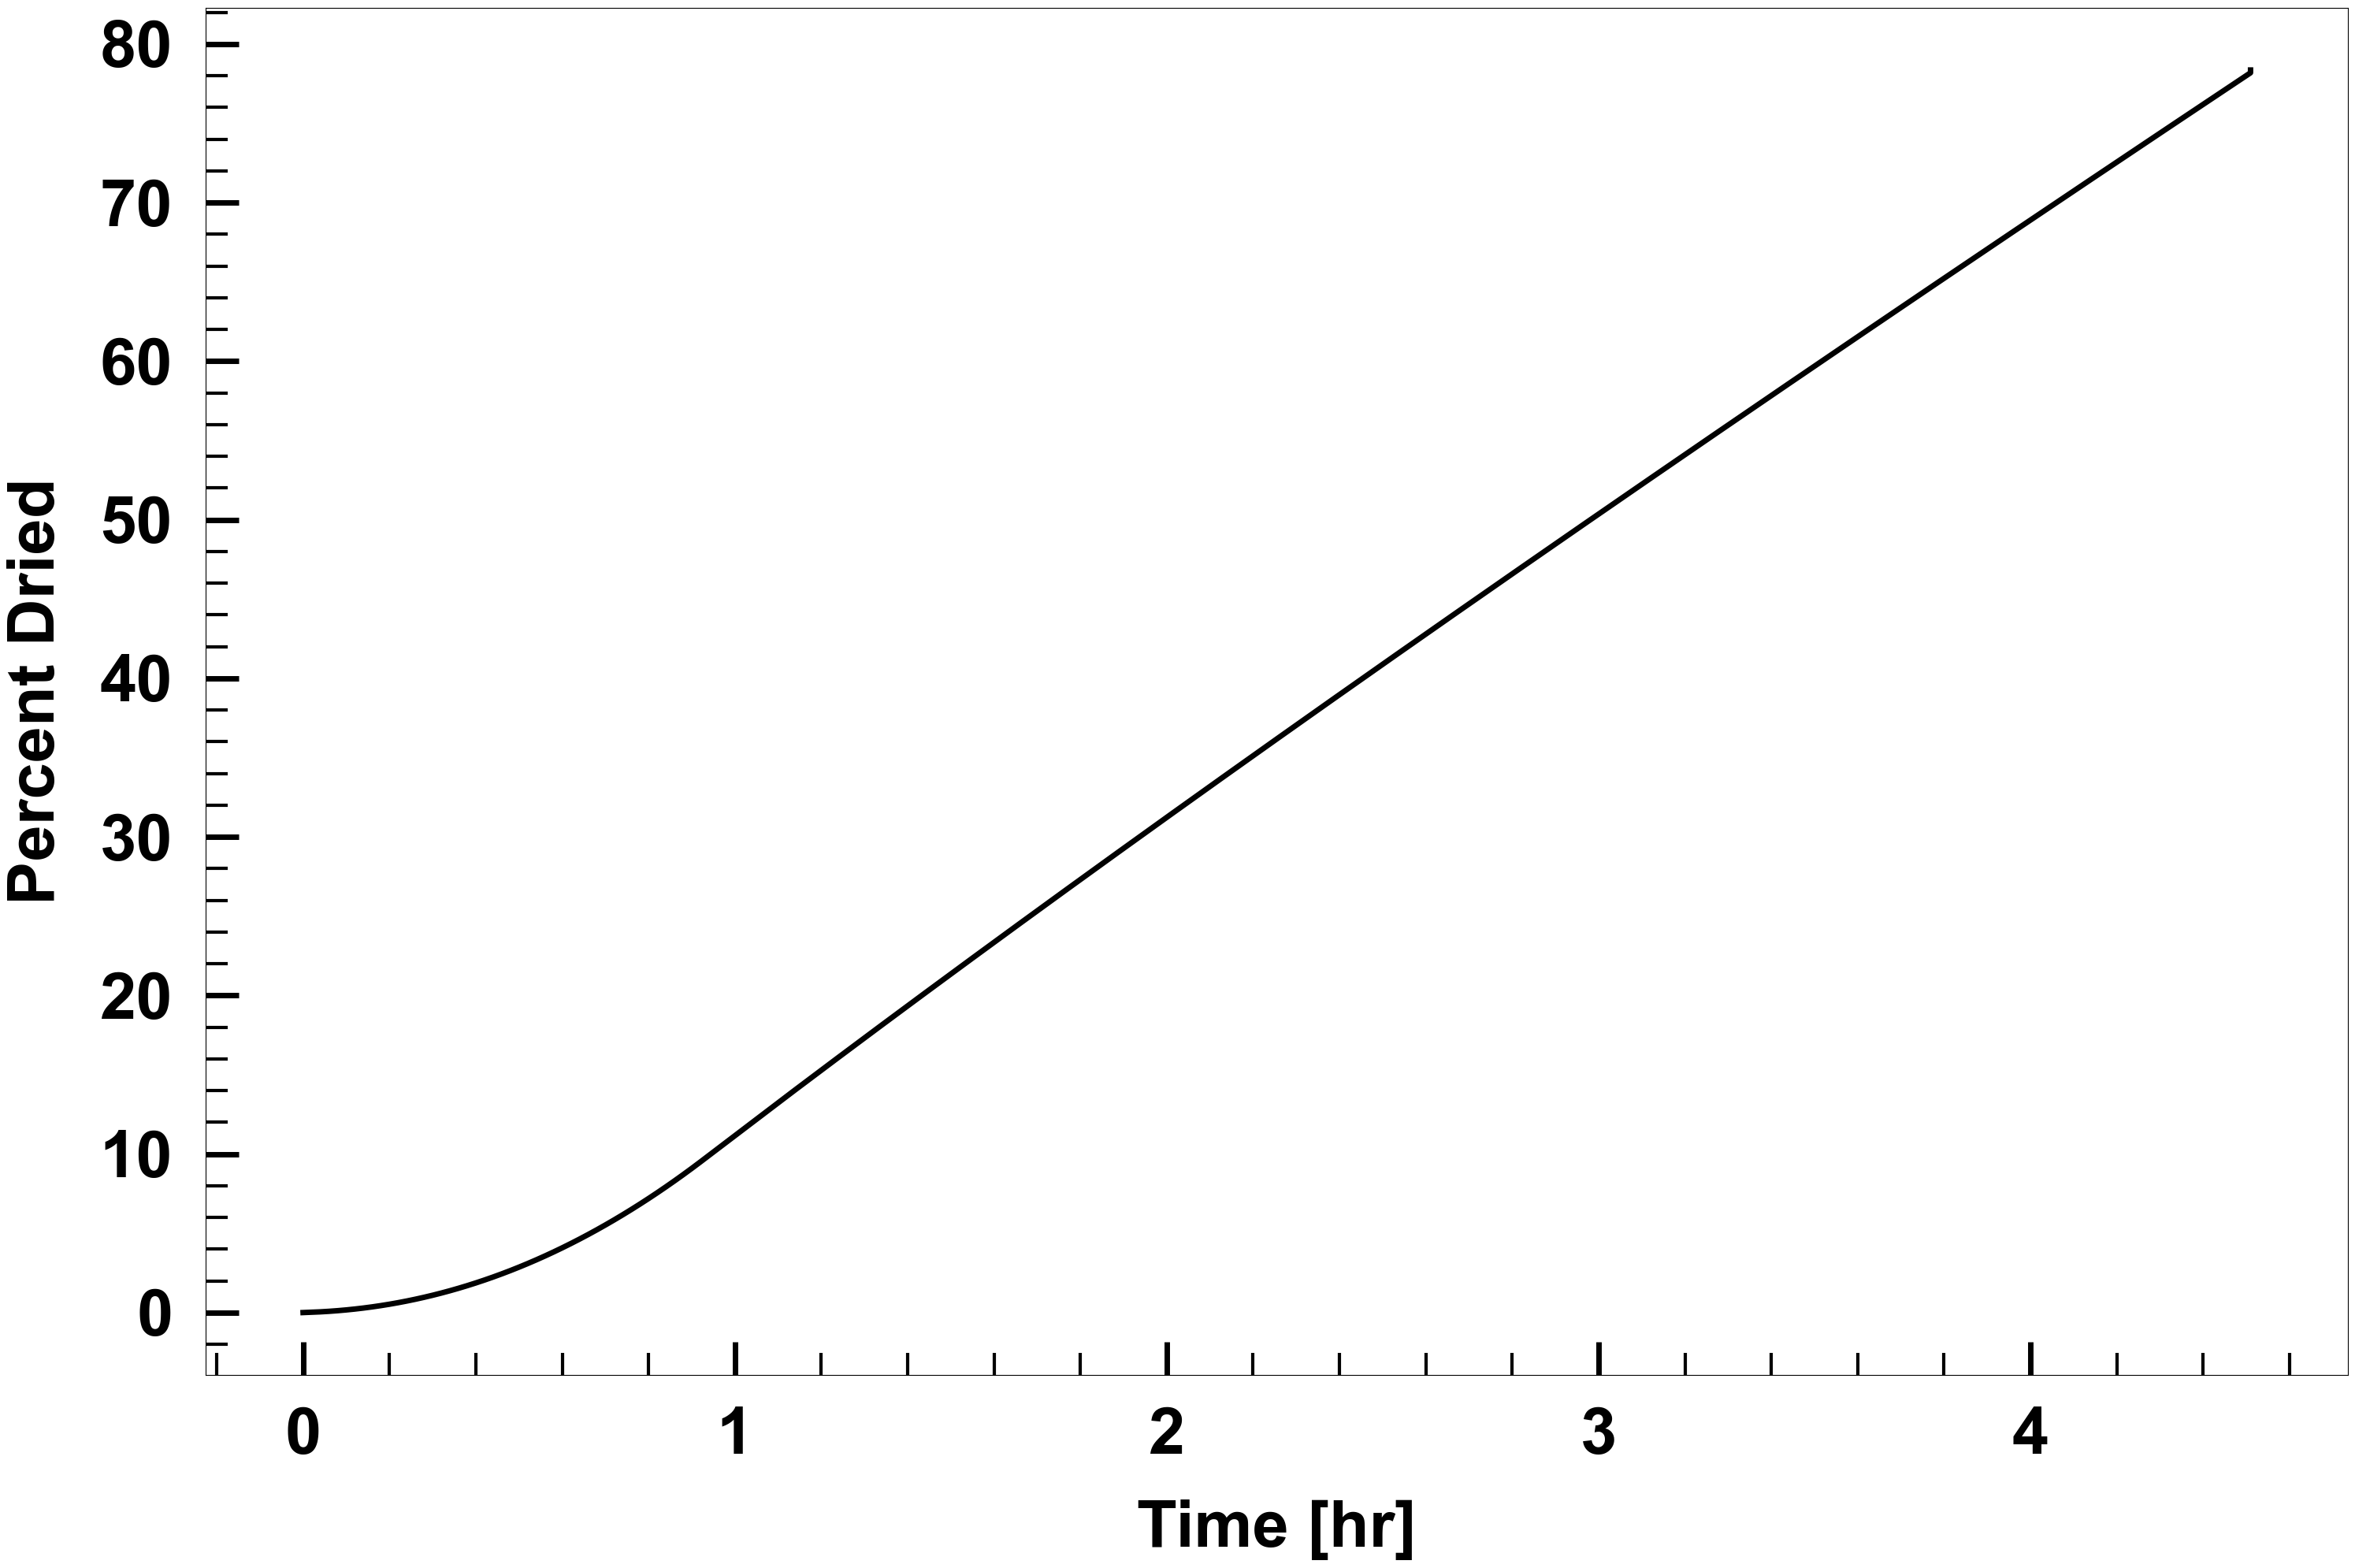

In [ ]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(1,1,1)
plt.axes(ax)
plt.minorticks_on()
plt.setp(ax.get_xticklabels(),fontsize=gcafontSize,fontweight='bold')
plt.setp(ax.get_yticklabels(),fontsize=gcafontSize,fontweight='bold')
ax.tick_params(axis='x',direction='in',pad=labelPad,width=majorTickWidth,length=majorTickLength,bottom=1,top=0)
ax.tick_params(axis='y',direction='in',pad=labelPad,width=majorTickWidth,length=majorTickLength,left=1,right=0)
ax.tick_params(axis='x',which='minor',direction='in',width=minorTickWidth,length=minorTickLength,bottom=1,top=0)
ax.tick_params(axis='y',which='minor',direction='in',width=minorTickWidth,length=minorTickLength,left=1,right=0)
ax.plot(output_saved[:,0],output_saved[:,-1],'-k',linewidth=lineWidth, label = "Percent Dried")
ax.set_xlabel("Time [hr]",fontsize=gcafontSize,fontweight='bold')
ax.set_ylabel("Percent Dried",fontsize=gcafontSize,fontweight='bold')
ax.xaxis.labelpad = labelPad
ax.yaxis.labelpad = labelPad
plt.tight_layout()
# figure_name = 'PercentDried_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()


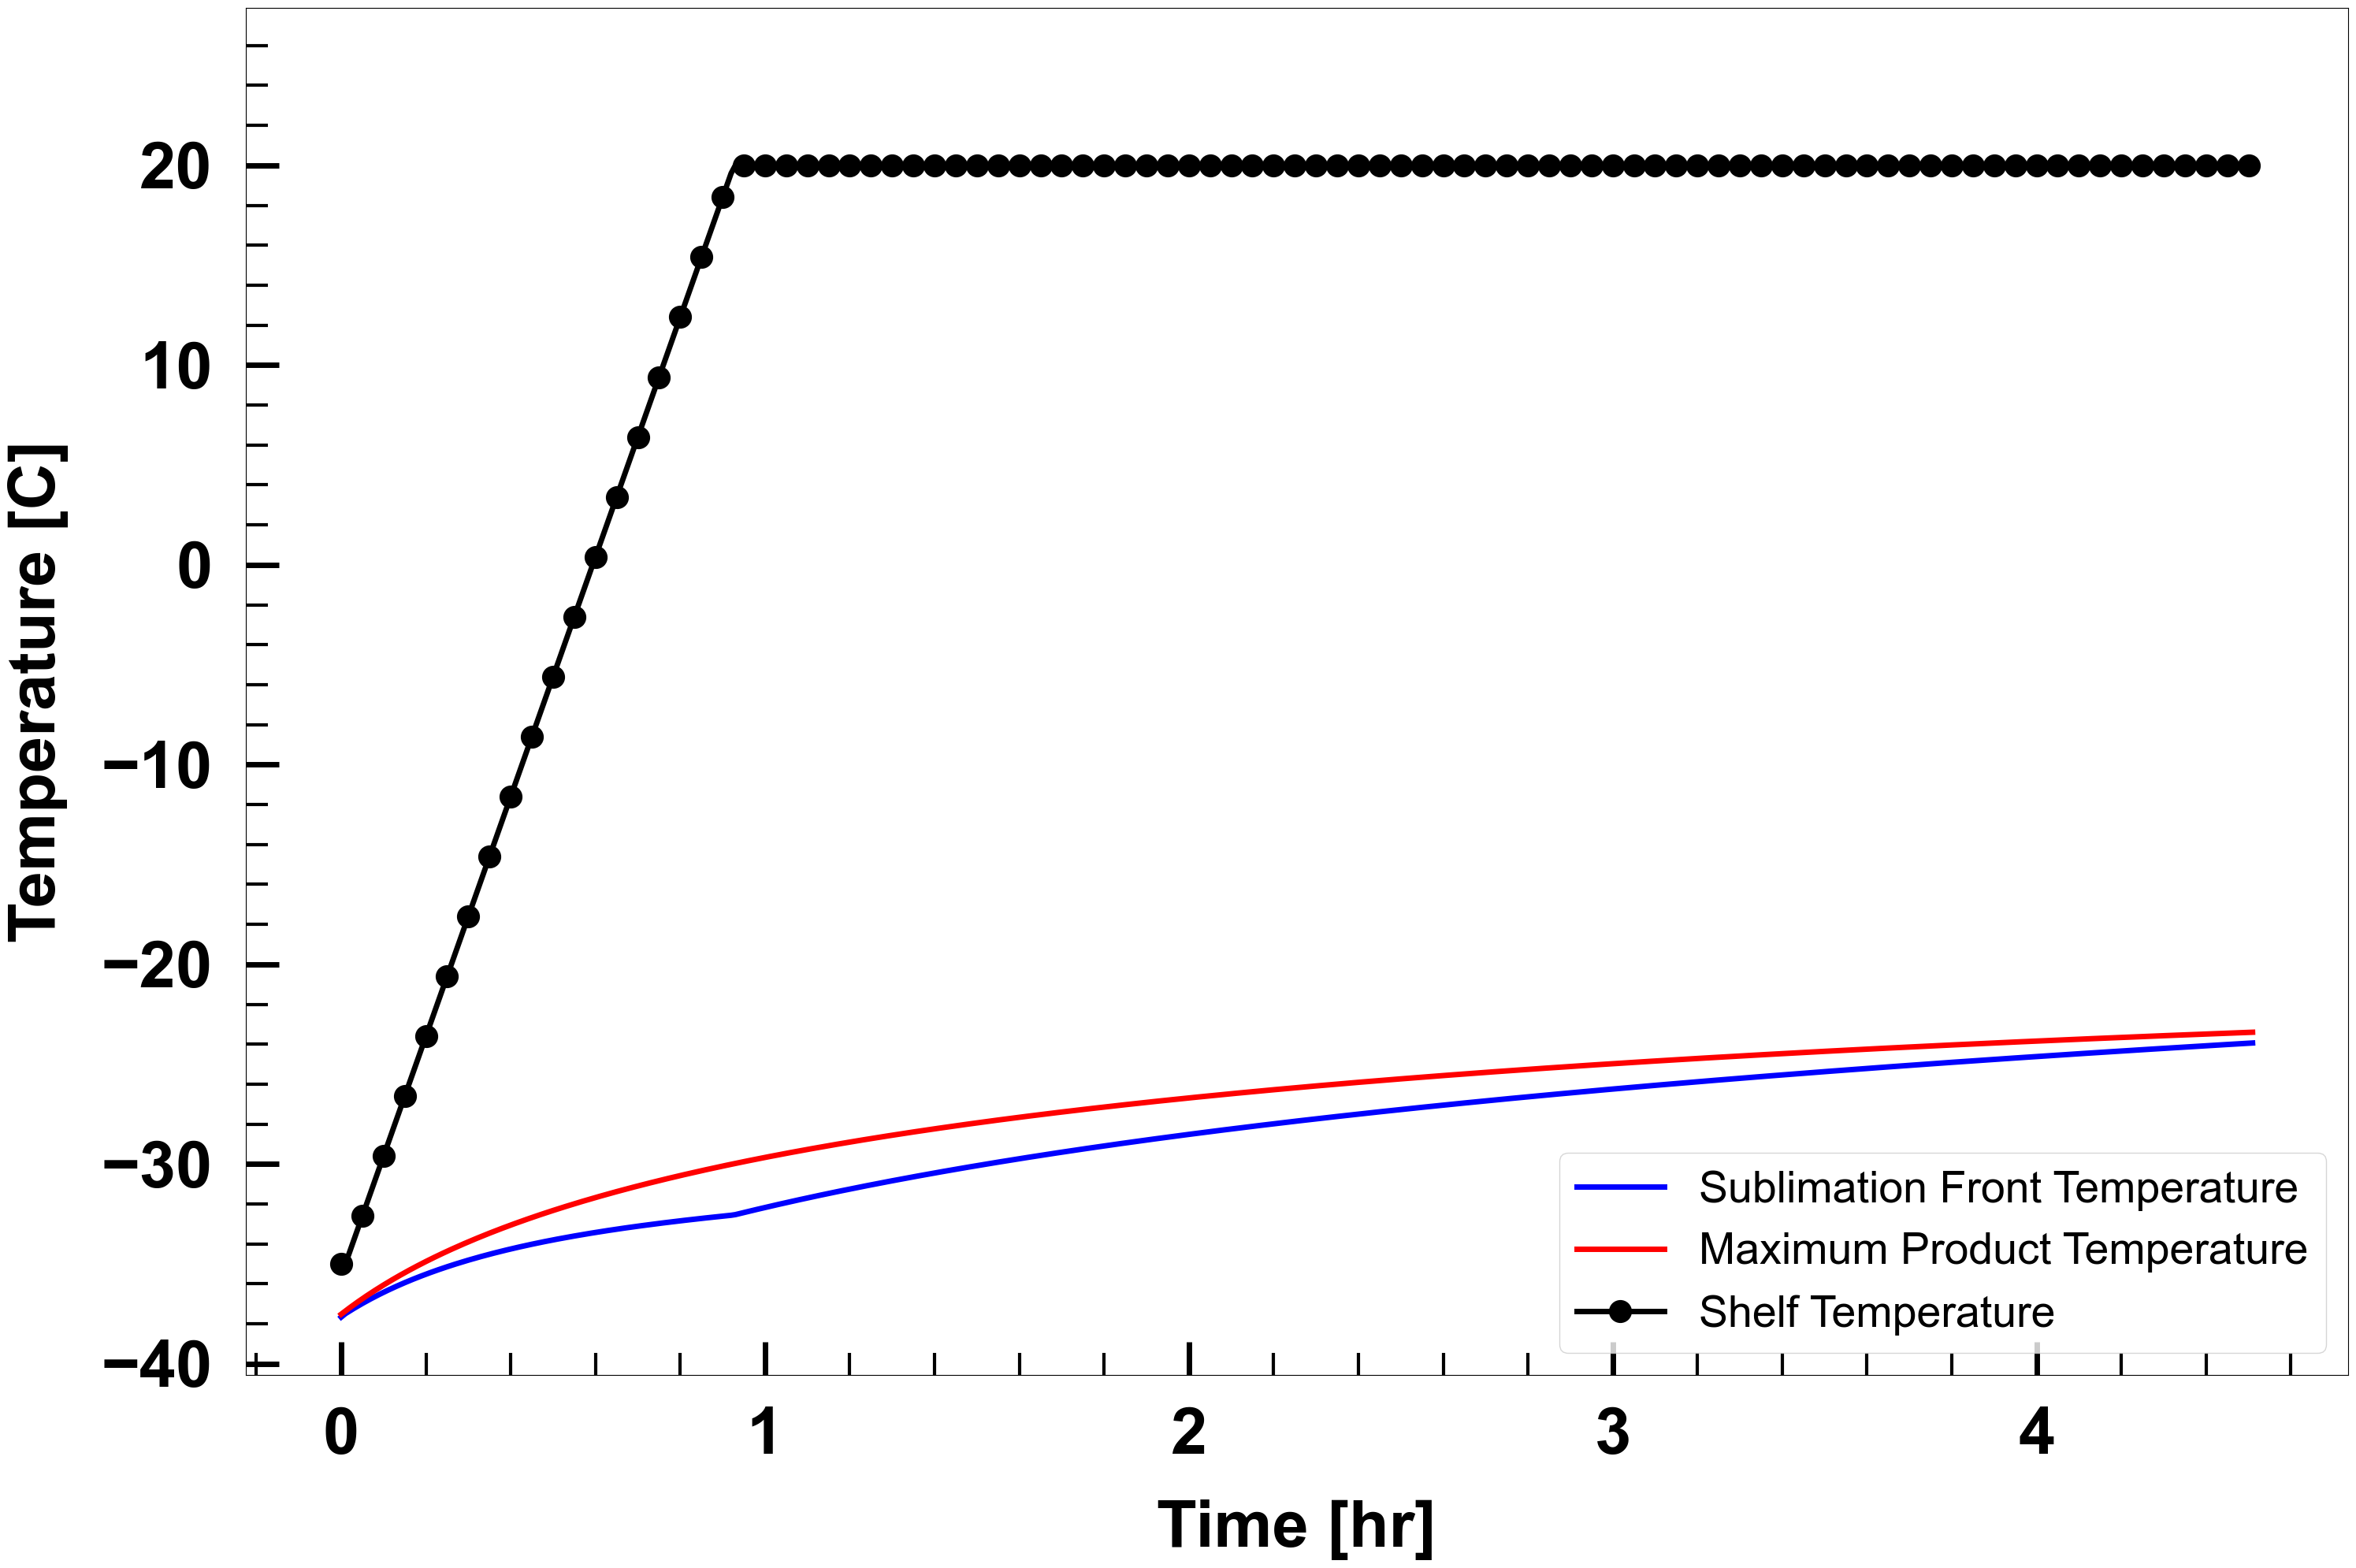

In [ ]:

fig = plt.figure(0,figsize=(figwidth,figheight))
ax = fig.add_subplot(1,1,1)
plt.axes(ax)
plt.minorticks_on()
plt.setp(ax.get_xticklabels(),fontsize=gcafontSize,fontweight='bold')
plt.setp(ax.get_yticklabels(),fontsize=gcafontSize,fontweight='bold')
ax.tick_params(axis='x',direction='in',pad=labelPad,width=majorTickWidth,length=majorTickLength,bottom=1,top=0)
ax.tick_params(axis='y',direction='in',pad=labelPad,width=majorTickWidth,length=majorTickLength,left=1,right=0)
ax.tick_params(axis='x',which='minor',direction='in',width=minorTickWidth,length=minorTickLength,bottom=1,top=0)
ax.tick_params(axis='y',which='minor',direction='in',width=minorTickWidth,length=minorTickLength,left=1,right=0)
ax.plot(output_saved[:,0],output_saved[:,1],'-b',linewidth=lineWidth, label = "Sublimation Front Temperature")
ax.plot(output_saved[:,0],output_saved[:,2],'-r',linewidth=lineWidth, label = "Maximum Product Temperature")
ax.plot(output_saved[:,0],output_saved[:,3],'-o',color='k',markevery=5,linewidth=lineWidth, markersize=markerSize, label = "Shelf Temperature")
ax.set_xlabel("Time [hr]",fontsize=gcafontSize,fontweight='bold')
ax.set_ylabel("Temperature [C]",fontsize=gcafontSize,fontweight='bold')
ax.xaxis.labelpad = labelPad
ax.yaxis.labelpad = labelPad
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles, labels, prop={'size':40},loc='best')
ll,ul = ax.get_ylim()
ax.set_ylim([ll,ul+5.0])
plt.tight_layout()
# figure_name = 'Temperatures_'+current_time+'.pdf'
# plt.savefig(figure_name)
# plt.close()
